# 实战手写数字识别

In [60]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
import gzip,os
import numpy as np 
import matplotlib.pyplot as plt

In [61]:
#transform = transforms.Compose([transforms.ToTensor(),
#                               transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])

In [62]:
#data_train = datasets.MNIST(root='./data/',transform=transform,train=True,download=True)
#data_test = datasets.MNIST(root='./data/',transform=transform,train=False)

In [63]:
# 加载MNIST数据集

# #************************************a2torchloadlocalminist*********************************************************
class DealDataset(Dataset):
    """
        读取数据、初始化数据
    """

    def __init__(self, folder, data_name, label_name, transform=None):
        (train_set, train_labels) = load_data(folder, data_name,
                                              label_name)  # 其实也可以直接使用torch.load(),读取之后的结果为torch.Tensor形式
        self.train_set = train_set
        self.train_labels = train_labels
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.train_set[index], int(self.train_labels[index])
        if self.transform is not None:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.train_set)


def load_data(data_folder, data_name, label_name):
    with gzip.open(os.path.join(data_folder, label_name), 'rb') as lbpath:  # rb表示的是读取二进制数据
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(os.path.join(data_folder, data_name), 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
    return (x_train, y_train)


train_dataset = DealDataset(r'E:\githubrepo\data\MNIST\raw', "train-images-idx3-ubyte.gz",
                           "train-labels-idx1-ubyte.gz", transform=transforms.ToTensor())
test_dataset = DealDataset(r'E:\githubrepo\data\MNIST\raw', "t10k-images-idx3-ubyte.gz",
                           "t10k-labels-idx1-ubyte.gz", transform=transforms.ToTensor())

# #************************************a2torchloadlocalminist*********************************************************

# train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
# test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())



In [64]:
data_train = train_dataset
data_test = test_dataset

In [65]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,batch_size=64,shuffle=True)
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,batch_size=64,shuffle=True)

[tensor(0), tensor(5), tensor(5), tensor(0), tensor(5), tensor(5), tensor(8), tensor(3), tensor(8), tensor(9), tensor(0), tensor(8), tensor(8), tensor(5), tensor(9), tensor(7), tensor(9), tensor(6), tensor(0), tensor(0), tensor(8), tensor(9), tensor(8), tensor(3), tensor(0), tensor(3), tensor(9), tensor(8), tensor(6), tensor(3), tensor(6), tensor(5), tensor(8), tensor(0), tensor(0), tensor(7), tensor(2), tensor(4), tensor(8), tensor(0), tensor(7), tensor(4), tensor(0), tensor(8), tensor(0), tensor(8), tensor(1), tensor(7), tensor(0), tensor(0), tensor(0), tensor(4), tensor(9), tensor(4), tensor(0), tensor(3), tensor(8), tensor(0), tensor(6), tensor(5), tensor(6), tensor(1), tensor(9), tensor(1)]


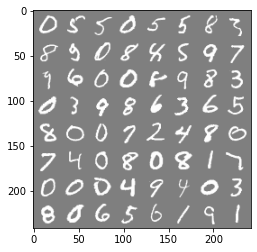

In [66]:
images, labels = next(iter(data_loader_train))
img = torchvision.utils.make_grid(images)

img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std + mean
print([labels[i] for i in range(64)])
plt.imshow(img)

In [67]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model,self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.MaxPool2d(stride=2,kernel_size=2))
        
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                        torch.nn.ReLU(),
                                        torch.nn.Dropout(p=0.5),
                                        torch.nn.Linear(1024,10))
        
    def forward(self,x):
        x = self.conv1(x)
        x = x.view(-1,14*14*128)
        x = self.dense(x)
        return x

In [68]:
model = Model()
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [70]:
n_epochs = 5

for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print('Epoch {}/{}'.format(epoch,n_epochs))
    print('-'*10)
    for data in data_loader_train:
        X_train, y_train = data
        X_train, y_train = Variable(X_train), Variable(y_train)
        outputs = model(X_train)
        _,pred = torch.max(outputs.data,1)
        optimizer.zero_grad()
        loss = cost(outputs,y_train)
        
        loss.backward()
        optimizer.step()
        #running_loss += loss.data[0]
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0
    for data in data_loader_test:
        X_test, y_test = data
        X_test, y_test = Variable(X_test), Variable(y_test)
        outputs = model(X_test)
        _,pred = torch.max(outputs.data,1)
        testing_correct += torch.sum(pred == y_test.data)
        print('Loss is:{:.4f},Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}'.format(running_loss/len(data_train),100*running_correct/
                                                                                        len(data_train),100*testing_correct/len(data_test)))

Epoch 0/5
----------
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:0.7038
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:1.3963
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:2.1113
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:2.8038
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:3.5076
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:4.2225
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:4.9374
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:5.6524
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:6.3450
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:7.0599
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:7.7636
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:8.4562
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:9.1711
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:9.8525
Loss is:0.0024,Train Accuracy is:95.0615%

Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:85.0536
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:85.7574
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:86.4611
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:87.1760
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:87.8686
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:88.5836
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:89.2985
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:90.0022
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:90.7060
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:91.4097
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:92.1247
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:92.8284
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:93.4987
Loss is:0.0024,Train Accuracy is:95.0615%, Test Accuracy is:94.2024
Loss is:0.0024,Train Accuracy is:95.0615%, Test 

Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:73.6037
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:74.3074
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:75.0223
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:75.7373
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:76.4522
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:77.1671
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:77.8709
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:78.5634
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:79.2784
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:79.9821
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:80.6747
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:81.3673
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:82.0599
Loss is:0.0007,Train Accuracy is:98.6209%, Test Accuracy is:82.7636
Loss is:0.0007,Train Accuracy is:98.6209%, Test 

Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:60.3217
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:61.0255
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:61.7404
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:62.4553
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:63.1702
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:63.8852
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:64.6001
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:65.3038
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:66.0188
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:66.7337
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:67.4374
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:68.1412
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:68.8561
Loss is:0.0005,Train Accuracy is:98.9795%, Test Accuracy is:69.5599
Loss is:0.0005,Train Accuracy is:98.9795%, Test 

Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:47.5871
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:48.3021
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:49.0170
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:49.7319
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:50.4468
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:51.1618
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:51.8767
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:52.5916
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:53.3065
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:54.0214
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:54.7252
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:55.4401
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:56.1550
Loss is:0.0004,Train Accuracy is:99.2585%, Test Accuracy is:56.8700
Loss is:0.0004,Train Accuracy is:99.2585%, Test 

Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:34.9643
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:35.6792
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:36.3941
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:37.1090
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:37.8240
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:38.5389
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:39.2538
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:39.9687
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:40.6836
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:41.3874
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:42.0912
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:42.8061
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:43.5098
Loss is:0.0003,Train Accuracy is:99.4754%, Test Accuracy is:44.2248
Loss is:0.0003,Train Accuracy is:99.4754%, Test 

Predict Label is: [tensor(9), tensor(3), tensor(1), tensor(0)]
Real Label is: [tensor(9), tensor(3), tensor(1), tensor(0)]


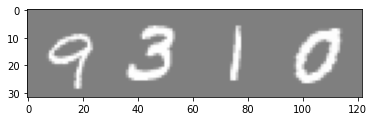

In [72]:
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,batch_size=4,shuffle=True)

X_test, y_test = next(iter(data_loader_test))
inputs = Variable(X_test)
pred = model(inputs)
_,pred = torch.max(pred,1)

print('Predict Label is:', [i for i in pred.data])
print('Real Label is:', [i for i in y_test])

img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1,2,0)

std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std + mean
plt.imshow(img)